# Task 2
We are provided with 100 images, accompanied with a csv file containing information about each object in the image. Each image has a varying number of objects, and hence their are a varying number of vectors (csv rows) representing each image. In other words, each image is represented by a varying number of feature vectors. 

A common approach to fact that each image is represented with a different number of feature vectors is to use Bag of Words (BoW). This method is commonly used to find similar images in a dataset (known as Visual Bag of Words - VBoW). The method is as follows:
1. The entire dataset is our corpus. We cluster the corpus into k clusters, and each cluster is represented by a centroid.
2. Each feature vector in the dataset is assigned to the cluster with the closest centroid. 
3. Each image is represented by a histogram of the number of feature vectors in each cluster. The histogram is normalized, and each word is weighted by its inverse appearance frequency (also known as inverse document frequency - IDF).
4. This histogram is the BoW representation of the image.

In our dataset we can separate the feature vectors into two sets: set number one is the information of the ego vehicle, and it is single for each image. Set number two is the information of the other objects in the image. This set changes in size for each image. Therefore we can represent the collection of objects in the image with BoW, and the ego vehicle with a single vector. The result will be a single vector for every image in the dataset.

We will cluster all the object detections using an autoencoder. The number of clusters in the autoencoder latent space will be the number of clusters in the BoW.
After each image will be represented by a single vector, we will train an autoencoder to learn the representation of the image. After training, the latent space will be used to classify the images using K-Means with cosine similarity.

## Data Preprocessing

In [ ]:
# PARAMETERS
LATENT_DIM = 3  # number of autoencoder latent dimensions
EPOCHS = 300   # number of training epochs
BATCH_SIZE = 2 # number of training samples per batch

In [3]:
import sklearn
import numpy as np
import csv
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib widget

# read the corpus
# ---------------
with open('data.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    data = list(reader)

data = np.array(data[1:]) # remove header
image_ids, csv_indices = np.unique(data[:,0], return_index=True) # get unique image ids and their indices

# create a dictionary mapping image ids to their indices
image_index_to_id = {i: image_id for i, image_id in enumerate(image_ids)}

# load a ego vector for each image
# --------------------------------
object_vectors = data[:, 2:8].astype(np.float32)

print('object_vectors.shape:', object_vectors.shape)

object_vectors.shape: (840, 6)


## Autoencoder
The dataset now contains 100 $X_{ego}$ vectors.
<img src="images/autoencoder.webp" width="400"/>

Now we will use a simple autoencoder to reduce the dimensionality of the data.
The input of the autoencoder is the $X_{ego}$ vector of size 6.
Another layer will be added to the autoencoder to reduce the dimensionality of the data to 2.

In [4]:
import torch
import torch.nn as nn

# Define the autoencoder class
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        
        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 3),
            nn.ReLU(),
            nn.Linear(3, latent_dim),
        )
        
        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 3),
            nn.ReLU(),
            nn.Linear(3, input_dim),
        )
    
        # initialize the weights
        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.5)

    def forward(self, x):
        # Encode the input
        encoded = self.encoder(x)
        
        # Decode the encoded input
        decoded = self.decoder(encoded)
        
        return encoded, decoded

# Create an instance of the autoencoder
input_dim = object_vectors.shape[1]  # Input dimension
latent_dim = LATENT_DIM  # Latent dimension

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

autoencoder = Autoencoder(input_dim, latent_dim)
autoencoder.to(device)
# Print the autoencoder architecture
print(autoencoder)


Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=6, out_features=3, bias=True)
    (1): ReLU()
    (2): Linear(in_features=3, out_features=3, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=3, bias=True)
    (1): ReLU()
    (2): Linear(in_features=3, out_features=6, bias=True)
  )
)


/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:98: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/pytorch/pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


## Training the Autoencoder For Objects


model saved
Epoch [1/300], Loss: 560.7701
Epoch [2/300], Loss: 1374.5361
model saved
Epoch [3/300], Loss: 526.3484
Epoch [4/300], Loss: 616.1406
model saved
Epoch [5/300], Loss: 258.4132
Epoch [6/300], Loss: 897.2531
Epoch [7/300], Loss: 266.5595
model saved
Epoch [8/300], Loss: 214.3211
model saved
Epoch [9/300], Loss: 96.3935
model saved
Epoch [10/300], Loss: 40.6257
model saved
Epoch [11/300], Loss: 12.7290
model saved
Epoch [12/300], Loss: 11.5636
Epoch [13/300], Loss: 15.9034
Epoch [14/300], Loss: 21.8288
Epoch [15/300], Loss: 20.9018
model saved
Epoch [16/300], Loss: 9.8901
Epoch [17/300], Loss: 13.7956
model saved
Epoch [18/300], Loss: 7.8648
Epoch [19/300], Loss: 7.8761
Epoch [20/300], Loss: 17.5308
Epoch [21/300], Loss: 10.5253
model saved
Epoch [22/300], Loss: 7.0969
Epoch [23/300], Loss: 7.5201
Epoch [24/300], Loss: 13.4101
model saved
Epoch [25/300], Loss: 4.6095
model saved
Epoch [26/300], Loss: 1.2921
Epoch [27/300], Loss: 2.5404
Epoch [28/300], Loss: 6.6144
Epoch [29/300

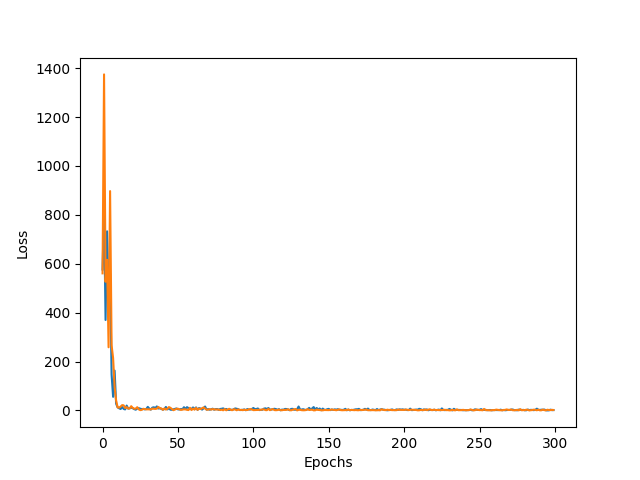

best epoch: 246, best loss: 0.27744922041893005


In [6]:
import torch.optim as optim

autoencoder = Autoencoder(input_dim, latent_dim)
autoencoder.to(device)

object_tensors = torch.from_numpy(object_vectors).to(device)
object_tensors = object_tensors.type(torch.FloatTensor)

# Define the loss function
criterion = nn.MSELoss()

# Define the optimizer
optimizer = optim.Adam(autoencoder.parameters(), lr=1E-4) #1E-4
# add a learning rate scheduler
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

# Train the autoencoder
num_epochs = EPOCHS
batch_size = BATCH_SIZE

loss_recorder= []
min_loss = 1000000
for epoch in range(num_epochs):
    # Shuffle the data
    indices = torch.randperm(object_tensors.size(0))
    shuffled_object_tensors = object_tensors[indices]
    
    # Split the data into batches
    num_batches = len(shuffled_object_tensors) // batch_size
    for i in range(num_batches):
        # Get a batch of data
        batch = shuffled_object_tensors[i * batch_size: (i + 1) * batch_size]
        
        # Move the batch to CUDA if available
        batch = batch.to(device)
        
        
        # Forward pass
        _, output = autoencoder(batch)
        
        # Compute the loss
        loss = criterion(output, batch)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # save best weights
    if loss.item() < min_loss:
        min_loss = loss.item()
        torch.save(autoencoder.state_dict(), 'best_model_task2.pth')
        print('model saved')
        best_epoch = epoch    
    # Decay the learning rate
    # scheduler.step()

    # add loss
    loss_recorder.append(loss.item())
    
    # Print the loss for every epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")#, Learning rate: {scheduler.get_lr()[0]:.8f}")

# Plot the loss
plt.plot(loss_recorder)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

print(f"best epoch: {best_epoch}, best loss: {min_loss}" )


## Run K-Means on the Latent Space
Now, lets pass the BoW representing each image and get the latent space representation. We will then run K-Means on the latent space, and use cosine similarity to classify the images.

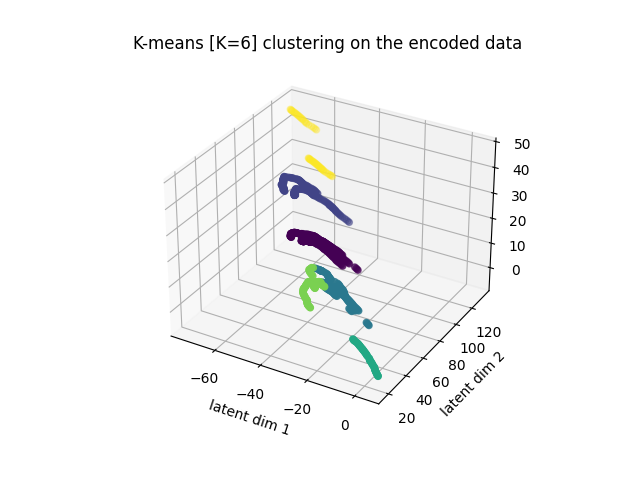

In [13]:
# Load the best model
autoencoder.load_state_dict(torch.load('best_model_task2.pth'))
autoencoder.to(device)
# use for inference
autoencoder.eval()

# Encode the data
encoded_data, _ = autoencoder(object_tensors.to(device))
encoded_data = encoded_data.detach().cpu().numpy()

# Run k-means on the encoded data
N_CLUSTERS = 6
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=0).fit(encoded_data)



# Plot the encoded data
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(encoded_data[:,0], encoded_data[:,1], encoded_data[:,2], c=kmeans.labels_, marker='o')
ax.set_xlabel('latent dim 1')
ax.set_ylabel('latent dim 2')
plt.title('K-means [K=6] clustering on the encoded data')
plt.show()

## BoW representation of objects
Looking at the results above, we can classify each object into one of the clusters.
Because each image has a different number of objects, we will use a Bag of Words (BoW) representation for each image. The BoW will represent the objects in the image, accompanied with the car ego information vector. This way each image will have a single vector representing both its ego car information and the objects in the image.

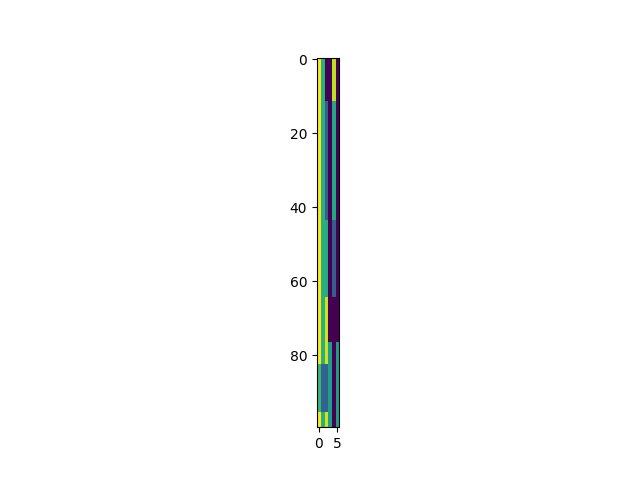

In [14]:
# classify each object to its cluster using the above kmeans and autoencoder
# -------------------------------------------------------------------------
# get the cluster of each object
words = kmeans.predict(encoded_data)

# calculate the tf-idf weights
# ----------------------------
# calculate the frequency of each word
word_freq = np.zeros(6)
for word in words:
    word_freq[word] += 1

# calculate the number of images containing each word (on log scale)
idf = np.log(len(image_ids) / 1 + word_freq)

# calculate the tf-idf weights
image_id_to_index = {v: k for k, v in image_index_to_id.items()}
images_BoW = np.zeros((len(image_ids), N_CLUSTERS))
for image_id, word in zip(data[:,0], words):
    images_BoW[image_id_to_index[image_id], word] += 1
images_BoW *= idf

plt.figure()
plt.imshow(images_BoW)

Now lets create a single vector for every image, using the ego car information and the BoW representation of the objects in the image.

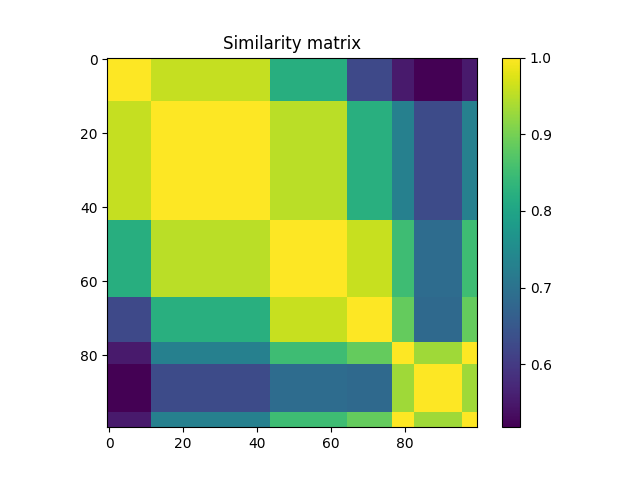

In [15]:
# create a single vector for each image
# -------------------------------------
# normalize the BoW vectors
images_BoW = sklearn.preprocessing.normalize(images_BoW, norm='l2', axis=1)


image_ids, csv_indices = np.unique(data[:,0], return_index=True) # get unique image ids and their indices

# load a ego vector for each image
# --------------------------------
ego_vectors = data[csv_indices,-6:].astype(np.float32)

images_vectors= np.concatenate((images_BoW, ego_vectors), axis=1)

# create a similirity matrix between different images regarding the objects in the images:
# Create a cosine similarity matrix
# ---------------------------------
from sklearn.metrics.pairwise import cosine_similarity
similarity_matrix = cosine_similarity(images_vectors[:, :6])

# Plot the similarity matrix
plt.figure()
plt.imshow(similarity_matrix)
plt.colorbar()
plt.title('Similarity matrix')
plt.show()

The cosine similarity between shows that there is a clear separation between the different situations of objects in the images.

# Clustering the images using the BoW representation with the autoencoder

In [ ]:

autoencoder = Autoencoder(images_vectors.shape[1], latent_dim)
autoencoder.to(device)

image_tensors = torch.from_numpy(images_vectors).to(device)
image_tensors = image_tensors.type(torch.FloatTensor)

# Define the loss function
criterion = nn.MSELoss()

# Define the optimizer
optimizer = optim.Adam(autoencoder.parameters(), lr=1E-4) #1E-4
# add a learning rate scheduler
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

# Train the autoencoder
num_epochs = 1000
batch_size = BATCH_SIZE

loss_recorder= []
min_loss = 1000000
for epoch in range(num_epochs):
    # Shuffle the data
    indices = torch.randperm(image_tensors.size(0))
    shuffled_image_tensors = image_tensors[indices]
    
    # Split the data into batches
    num_batches = len(shuffled_image_tensors) // batch_size
    for i in range(num_batches):
        # Get a batch of data
        batch = shuffled_image_tensors[i * batch_size: (i + 1) * batch_size]
        
        # Move the batch to CUDA if available
        batch = batch.to(device)
        
        
        # Forward pass
        _, output = autoencoder(batch)
        
        # Compute the loss
        loss = criterion(output, batch)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # save best weights
    if loss.item() < min_loss:
        min_loss = loss.item()
        torch.save(autoencoder.state_dict(), 'best_model_task2_2.pth')
        print('model saved')
        best_epoch = epoch    
    # Decay the learning rate
    # scheduler.step()

    # add loss
    loss_recorder.append(loss.item())
    
    # Print the loss for every epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")#, Learning rate: {scheduler.get_lr()[0]:.8f}")

# Plot the loss
plt.figure()
plt.plot(loss_recorder)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

print(f"best epoch: {best_epoch}, best loss: {min_loss}" )


In [ ]:
# Load the best model
autoencoder.load_state_dict(torch.load('best_model_task2_2.pth'))
autoencoder.to(device)
# use for inference
autoencoder.eval()

# Encode the data
encoded_data, _ = autoencoder(image_tensors.to(device))
encoded_data = encoded_data.detach().cpu().numpy()

# Run k-means on the encoded data
N_CLUSTERS = 8
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=0).fit(encoded_data)



# Plot the encoded data
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(encoded_data[:,0], encoded_data[:,1], encoded_data[:,1], c=kmeans.labels_, marker='o')
ax.set_xlabel('latent dim 1')
ax.set_ylabel('latent dim 2')
plt.title('K-means [K=6] clustering on the encoded data')
plt.show()

### Store the images according to their clusters
Each image will be stored under `/task_1/cluster_i` where i is the cluster number the image belongs to.

In [ ]:
import os
import shutil
os.makedirs('task_3', exist_ok=True)

data_path = "/DATA/Autobrains/EON/Images/"
# find the cluster of each image and copy it to a folder
for image_id, cluster in enumerate(kmeans.labels_):
    cluster = int(cluster)   
    image_path = image_index_to_id[image_id] + ".png"
    if os.path.exists(data_path + image_path):
        os.makedirs(f'task_3/{cluster}', exist_ok=True)
        shutil.copy(data_path + image_path, f'task_3/{cluster}/'+image_path)

    else: 
        print(f'Image {data_path + image_path} not found')
        
        